# Labelfunction and model analysis

imports

In [1]:
from fonduer.supervision import Labeler
from fonduer.features import Featurizer
from fonduer.candidates.models import Candidate

from snorkel.labeling import LFAnalysis
from snorkel.labeling.model import LabelModel

from pipeline.utils import get_session, load_candidates
from definitions.candidates import NameFullAbbr, NameFullTask
from pipeline.lfs.dummy_lfs import dummy_lfs


Get session object

In [2]:
session = get_session(db_name="supervision")

[2023-05-03 21:13:08,192][INFO] fonduer.meta:49 - Setting logging directory to: /tmp/2023-05-03_21-13-08


Define candidates and Labeler object

In [3]:
candidates = [NameFullTask, NameFullAbbr]
labeler = Labeler(session, candidates)

Load candidates and labels

In [4]:
train_cands = load_candidates(session, 0, candidates)
L_train_NFT, L_train_NFA = labeler.get_label_matrices(train_cands) # NFT --> NameFullTask, NFA --> NameFullAbbr

/workspaces/bio-medRxiv/pipeline/utils.py:39: SAWarning: Coercing Subquery object into a select() for use in IN(); please pass a select() construct explicitly
  cands = (session.query(candidate_class).filter(candidate_class.id.in_(sub_query)).order_by(candidate_class.id).all())


## LF analysis

NameFull + Abrreviation

In [7]:
LFAnalysis(
    L_train_NFA,
    lfs=sorted(dummy_lfs, key=lambda lf: lf.name)
).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
dummy_lf_rand,0,"[0, 1]",1.0,1.0,0.749063
dummy_lf_randi,1,"[0, 1]",1.0,1.0,0.749063
dummy_lf_rando,2,"[0, 1]",1.0,1.0,0.749063


NameFull + Task

In [8]:
LFAnalysis(
    L_train_NFT,
    lfs=sorted(dummy_lfs, key=lambda lf: lf.name)
).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
dummy_lf_rand,0,"[0, 1]",1.0,1.0,0.749727
dummy_lf_randi,1,"[0, 1]",1.0,1.0,0.749727
dummy_lf_rando,2,"[0, 1]",1.0,1.0,0.749727


## Model analysis

List of models

| Modelname | Candidate | description | n_epochs |
| --------- | --------- | ----------- | -------- |
| label_model_v1_NFA | NameFullAbbr | label model with random label functions | 500 |
| label_model_v1_NFT | NameFullTask | label model with random label functions | 500 |

In [9]:
from pathlib import Path

gen_model_NFT = LabelModel(cardinality=2)
gen_model_NFA = LabelModel(cardinality=2)


if Path("models/label_model_NFA_v1.pkl").is_file() and Path("models/label_model_NFT_v1.pkl").is_file():
    gen_model_NFA.load(source="models/label_model_NFA_v1.pkl")
    gen_model_NFT.load(source="models/label_model_NFT_v1.pkl")
    print("Loaded Models")
else:
    gen_model_NFT.fit(L_train_NFT, n_epochs=500, log_freq=100)
    gen_model_NFT.save("models/label_model_NFT_v1.pkl")

    gen_model_NFA.fit(L_train_NFA, n_epochs=500, log_freq=100)
    gen_model_NFA.save("models/label_model_NFA_v1.pkl")
    print("Fit and saved models")

[2023-05-03 21:14:19,579][INFO] root:905 - Computing O...
[2023-05-03 21:14:19,582][INFO] root:911 - Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s][2023-05-03 21:14:19,590][INFO] root:79 - [0 epochs]: TRAIN:[loss=2.302]
[2023-05-03 21:14:19,654][INFO] root:79 - [100 epochs]: TRAIN:[loss=0.001]
 60%|██████    | 300/500 [00:00<00:00, 1321.32epoch/s][2023-05-03 21:14:19,812][INFO] root:79 - [300 epochs]: TRAIN:[loss=0.000]
[2023-05-03 21:14:19,876][INFO] root:79 - [400 epochs]: TRAIN:[loss=0.000]
100%|██████████| 500/500 [00:00<00:00, 1412.25epoch/s]
[2023-05-03 21:14:19,943][INFO] root:977 - Finished Training
[2023-05-03 21:14:19,957][INFO] root:905 - Computing O...
[2023-05-03 21:14:19,961][INFO] root:911 - Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s][2023-05-03 21:14:19,963][INFO] root:79 - [0 epochs]: TRAIN:[loss=2.301]
[2023-05-03 21:14:20,028][INFO] root:79 - [100 epochs]: TRAIN:[loss=0.000]
 31%|███       | 155/500 [00:00<00:00, 1546.41epoch/s][2023-05

Fit and saved models


### Generating train marginals

In [10]:
train_marginals_NFA = gen_model_NFA.predict_proba(L_train_NFA)
train_marginals_NFT = gen_model_NFT.predict_proba(L_train_NFT)

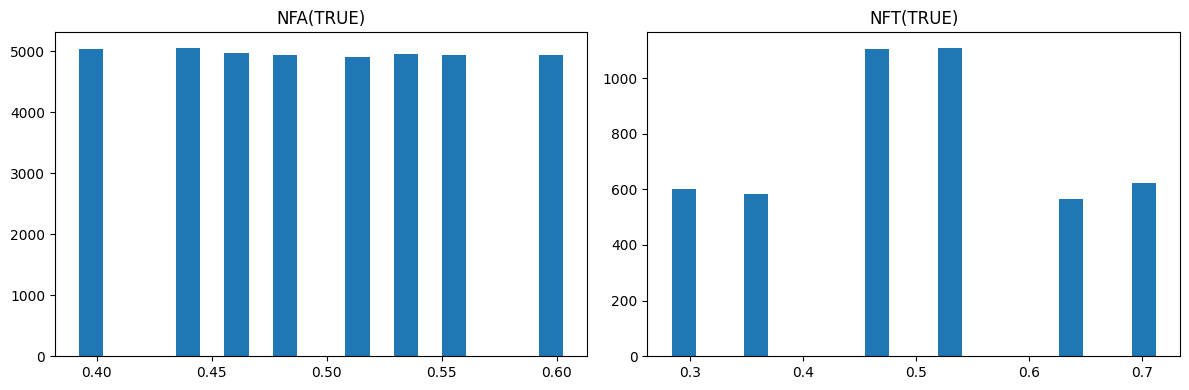

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(12)
fig.set_tight_layout("w_pad")

bins=20

ax[0].hist(train_marginals_NFA[:, 0], bins=bins)
ax[0].set_title("NFA(TRUE)")

ax[1].hist(train_marginals_NFT[:, 0], bins=bins)
ax[1].set_title("NFT(TRUE)")
plt.show()

### Iterate on LFs

In [12]:
dev_cands = load_candidates(session, split=1, candidate_list=candidates)

L_dev_NFA, L_dev_NFT = labeler.get_label_matrices(dev_cands)

/workspaces/bio-medRxiv/pipeline/utils.py:39: SAWarning: Coercing Subquery object into a select() for use in IN(); please pass a select() construct explicitly
  cands = (session.query(candidate_class).filter(candidate_class.id.in_(sub_query)).order_by(candidate_class.id).all())
/usr/local/lib/python3.8/site-packages/fonduer/utils/utils_udf.py:217: SAWarning: Coercing Subquery object into a select() for use in IN(); please pass a select() construct explicitly
  .filter(candidate_class.id.in_(sub_query))
[2023-05-03 21:14:30,468][INFO] fonduer.supervision.labeler:330 - Clearing Labels (split 1)
/usr/local/lib/python3.8/site-packages/fonduer/supervision/labeler.py:340: SAWarning: Coercing Subquery object into a select() for use in IN(); please pass a select() construct explicitly
  query = self.session.query(table).filter(table.candidate_id.in_(sub_query))
[2023-05-03 21:14:30,667][INFO] fonduer.utils.udf:67 - Running UDF...


  0%|          | 0/1 [00:00<?, ?it/s]

## Discriminative Model

extract words from train_cands and count them

In [13]:
import numpy as np
# calculate the diff between true and false prediction probability of each candidate
# the bigger the difference the more certain the model is
# Example True = 0.4 False = 0.6
# diff = 0.6 - 0.4 = 0.2 --> model is very unsure 
diffs = train_marginals_NFT.max(axis=1) - train_marginals_NFT.min(axis=1)

# filter out all candidates where labelmodel is very unsure
# unsure is a diff of smaller then 0.000001
train_idxs = np.where(diffs > 0.2)[0].astype(np.int64)
filtered = train_marginals_NFT[train_idxs, 1]

# Cast continous values to binary for logistic regression model
y = np.where(filtered > 0.5, 1, 0)

Get feature matrix and filter with previous filter

In [14]:
featurizer = Featurizer(session, candidates)

In [15]:
F_train_NFT = featurizer.get_feature_matrices(train_cands)[0]
X = F_train_NFT[train_idxs, :]


train logistic regression model

In [19]:
from sklearn.linear_model import LogisticRegression, BayesianRidge

clf = LogisticRegression(max_iter=200).fit(X, y)

In [20]:
test_cands = load_candidates(session, 2, candidates)
F_test_NFT = featurizer.get_feature_matrices(test_cands)[0]

preds = clf.predict(F_test_NFT)

/workspaces/bio-medRxiv/pipeline/utils.py:39: SAWarning: Coercing Subquery object into a select() for use in IN(); please pass a select() construct explicitly
  cands = (session.query(candidate_class).filter(candidate_class.id.in_(sub_query)).order_by(candidate_class.id).all())


In [23]:
reg = BayesianRidge().fit(X.toarray(), y)